## Importing Librarires

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# Updating matplotlib parameters to match default LaTeX font
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [2]:
# Run in the system if never ran before
#pip install xgboost shap
#pip install pykalman

# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.inspection import permutation_importance
from pykalman import KalmanFilter

## Loading Raw Datasets

In [3]:
# Defining start and end dates to import data
start_date = datetime(2000,1,1)
end_date = datetime(2025,1,1)

In [4]:
# Importing raw datasets
raw_data_bonds = pd.read_csv("bond_returns.csv")
raw_data_bloomb = pd.read_csv("bb_index_data.csv")
raw_1m_tbill = web.DataReader('DGS1MO', 'fred', start_date, end_date) # 1-M T-Bill rate

In [5]:
# Printing out the dataframe to see how they look like 
print("Head of the Corporate Bonds Dataset\n")
print(raw_data_bonds.head(10))
print("\nInfo on Corporate Bonds Dataset\n")
print(raw_data_bonds.info())
print("\nHead of the Bloomberg Index\n")
print(raw_data_bloomb.head(10))
print("\nInfo on Bloomberg Index Dataset\n")
print(raw_data_bloomb.info())
print("Head of the 1-M T-Bill data")
print(raw_1m_tbill.head(10))
print("\nInfo on 1-M T-Bill Data")
print(raw_1m_tbill.info())

Head of the Corporate Bonds Dataset

          eom      cusip   permno  market_value   ret_exc  ret_texc     yield  \
0  2002-07-31  000336AE7  75188.0  9.762500e+07       NaN       NaN  0.073811   
1  2002-08-31  000336AE7  75188.0  9.769300e+07  0.005084 -0.013903  0.073719   
2  2002-09-30  000336AE7  75188.0  9.169149e+07 -0.056349 -0.084103  0.087643   
3  2002-10-31  000336AE7  75188.0  9.600000e+07  0.050924  0.056538  0.077713   
4  2002-11-30  000336AE7  75188.0  1.034310e+08  0.079503  0.102248  0.061296   
5  2003-01-31  000336AE7  75188.0  1.042860e+08       NaN       NaN  0.059218   
6  2003-03-31  000336AE7  75188.0  8.613923e+07       NaN       NaN  0.104091   
7  2003-04-30  000336AE7  75188.0  9.003247e+07  0.049914  0.048978  0.093874   
8  2003-07-31  000336AE7  75188.0  9.910588e+07       NaN       NaN  0.070938   
9  2003-08-31  000336AE7  75188.0  9.768750e+07 -0.009317 -0.007545  0.074590   

   duration rating_group  
0  4.652351          IG-  
1  4.572442      

## Data Exploration

### TRACE Dataset Column Descriptions

| Column         | Description |
|----------------|-------------|
| **cusip**      | 9-digit CUSIP identifier for the bond. Uniquely identifies the specific debt instrument. |
| **permno**     | Unique permanent security identifier (CRSP PERMNO) that links the bond to an issuer's equity (if available). Useful for merging with equity-level data. |
| **market_value** | Market value of the bond at the end of the month. This includes accrued interest and reflects the value used for portfolio weighting. |
| **ret_exc**    | **Excess return** on the bond: the bond's total return minus the return on a 1-month U.S. Treasury bill. This isolates the bond's performance relative to a cash benchmark. |
| **ret_texc**   | **Pure credit excess return**: the bond's total return minus the return on a **duration-matched Treasury portfolio**, where each bond cash flow is hedged using zero-coupon Treasuries of the same maturity. This isolates credit performance by removing both interest rate level and curve exposure. |
| **yield**      | Yield to maturity or yield to worst of the bond, expressed as an annualized percentage. Reflects the expected return if the bond is held to maturity. |
| **duration**   | Modified duration of the bond. Measures interest rate sensitivity — i.e., the approximate percentage change in price for a 1% change in yield. |
| **rating_group** | Credit rating group of the bond (e.g., AAA, AA, A, BBB, etc.), likely mapped into buckets such as Investment Grade (IG) or High Yield (HY). Helps group bonds by credit quality. |


### Bloomberg US Corporate Bond Index Dataset (LUACTRUU Index)

| Column                          | Description |
|----------------------------------|-------------|
| **LUACTRUU Index**              | Bloomberg ticker for the **Bloomberg US Corporate Total Return Index (Unhedged USD)**. This is the benchmark index composed of USD-denominated investment grade corporate bonds. The column typically contains dates (i.e., row index) if this is the leftmost column. |
| **PX_LAST**                    | Last traded price or closing level of the index on a given date. This is usually the same as the total return index level if no other price series is specified. |
| **PX_MID**                     | Mid price level of the index, representing the average of the bid and ask index pricing. May differ from `PX_LAST` depending on timing and methodology. |
| **TOT_RETURN_INDEX_GROSS_DVDS** | Total return index level including **gross reinvestment of coupons (dividends)**. It reflects the cumulative value of $1 invested in the index, assuming all cash flows are reinvested without withholding tax. Used to compute total returns over time. |
| **CPN**                        | Weighted average **coupon rate** of bonds in the index, expressed as a percentage. Reflects the average nominal interest rate across constituents. |
| **CUR_MKT_CAP**                | **Current market capitalization** of the index, i.e., the total market value of all bonds in the index on the given date. Reflects index size and investable universe. |
| **INDEX_YIELD_TO_WORST**       | Weighted average **yield to worst (YTW)** for the index. This is the lowest yield an investor can earn assuming any callable bonds are redeemed at the most disadvantageous time for the investor. Expressed as annualized %. |
| **INDEX_YIELD_TO_MATURITY**    | Weighted average **yield to maturity (YTM)** for all bonds in the index. This is the internal rate of return assuming each bond is held to its maturity and pays all scheduled cash flows. |
| **COUNT_INDEX_MEMBERS**        | Number of individual **bond issues** currently included in the index. Useful for understanding diversification and size over time. |


### Data Cleaning Pipeline

#### Corporate Bond Dataset

First seeing how many bonds belong to Investment Grade and Junk categories, and only keeping the Investment Grade Bonds.

| Rating Group | Full Form                   | Description                                | Example Ratings         | Credit Risk      |
|--------------|-----------------------------|--------------------------------------------|--------------------------|------------------|
| IG+          | Investment Grade (High)     | Highest quality bonds with minimal risk    | AAA, AA (S&P/Fitch), Aaa, Aa (Moody's) | Very Low         |
| IG-          | Investment Grade (Low)      | Still considered safe, but lower tier      | A, BBB (S&P/Fitch), A, Baa (Moody's)    | Low to Moderate  |
| SG           | Speculative Grade (High Yield) | Below investment grade; riskier            | BB, B, CCC, etc. (S&P/Fitch), Ba, B, Caa (Moody's) | High             |


In [6]:
print(raw_data_bonds['rating_group'].unique())
raw_data_bonds['rating_group'].value_counts()

['IG-' 'SG' 'IG+']


rating_group
IG+    705593
IG-    594906
SG     324878
Name: count, dtype: int64

In [7]:
# Building function to clean the corporate bonds dataset
def cleaning_bonds_data (bonds_raw_data : pd.DataFrame) -> pd.DataFrame:
    '''
    A function which performs all the data cleaning exercises for the corporate bonds
    dataset (TRACE) and outputs the processed dataframe for data exploration. 
    '''
    # 1) Filterng out High-Yield bonds
    output_df = bonds_raw_data[bonds_raw_data['rating_group'] != 'SG'].copy()

    # 2) Converting the EOM column to 'date' and into pandas datetime format
    output_df['eom'] = pd.to_datetime(output_df['eom'], format='%Y-%m-%d', errors='raise')
    
    # 3) Sorting the resulting dataframe in a chronological order
    output_df.sort_values(by='eom', inplace=True)

    # 4) Dropping unnecessary columns
    output_df.drop(['permno', 'ret_texc', 'yield', 'duration', 'rating_group'],
                   axis=1, inplace=True)
    output_df.rename(columns={'eom': 'Date'}, inplace=True)
    
    # 5) Resetting the index
    output_df.set_index('Date', inplace=True)

    # Returning the resulting dataframe
    return output_df

In [8]:
# Creating a function to pivot the processed bonds dataset, to structure bond returns as features
def pivot_bonds_data (clean_bonds_data : pd.DataFrame) :
    """
    A function which takes as input the processed bonds dataset, and changes the structure of this
    dataframe such that the rows are just the dates, and each date has all available bonds as 
    the columns (features). This structure will make it easier to feed this data into the models.
    Returns a dictionary of wide-format dataframes where each key corresponds to a bond-level feature.
    Column names will be the CUSIP of each bond.
    Also drop those bonds who have 1 or less non-null values
    """
    # Creating necessary variables
    interim_df = clean_bonds_data.reset_index()
    
    # Creating dataframe with bond returns
    pivot_bond_returns = interim_df.pivot(index='Date', columns='cusip', values='ret_exc')

    # Filtering out bonds with 1 or less valid observations
    drop_list = pivot_bond_returns.columns[pivot_bond_returns.count() <= 1].tolist()

    # Dropping irrelevant rows and columns
    pivot_bond_returns.drop(columns=drop_list, inplace=True)
    pivot_bond_returns = pivot_bond_returns.iloc[1:]
    
    # Creating another dataframe with bond MCap
    pivot_bond_mcap = interim_df.pivot(index='Date', columns='cusip', values='market_value')
    pivot_bond_mcap.drop(columns=drop_list, inplace=True)
    
    return {
        'bond_returns' : pivot_bond_returns,
        'bond_mcap' : pivot_bond_mcap
    }

#### Bloomberg Index Dataset

In [9]:
# Building a function to clean the Bloomberg index dataset
def cleaning_index_data (index_raw_data : pd.DataFrame,
                         clean_tbill : pd.DataFrame,
                        start_index : pd.Timestamp,
                        end_index : pd.Timestamp) -> pd.DataFrame:
    """
    A function which performs all the data cleaning exercises for the Bloomberg index data 
    (LUACTRUU) and outputs the processed dataframe for data exploration.
    Function also calculates excess returns over T-Bill rate, and assumes the the T-Bill 
    data which is being passed as input has been sliced with the same dates as the bonds.
    """
    # Creating output dataframe and neccessary variables
    interim_df = index_raw_data.copy()
    first_col_name = index_raw_data.columns[0]
    index_value_col = index_raw_data.columns[3]
    
    # 1) Renaming Date column and setting it as the index
    interim_df.rename(columns={first_col_name:'Date',
                             index_value_col:first_col_name}, inplace=True)
    interim_df['Date'] = pd.to_datetime(interim_df['Date'], format="%d-%m-%Y", errors='raise')
    interim_df.set_index('Date', inplace=True)

    # 2) Resampling the dataframe to match Monthly Frequency
    interim_df = interim_df.resample("ME").last()

    # 3) Calculating Returns
    interim_df['Returns'] = (interim_df['PX_LAST'] / interim_df['PX_LAST'].shift(1)) - 1
    
    # 4) Slicing the dataframe to match the bonds dataset
    interim_df = interim_df[interim_df.index >= start_index]
    interim_df = interim_df[interim_df.index <= end_index]
    
    # 4) Creating final dataframe with relevant columns
    output_df = pd.DataFrame(index = interim_df.index)
    output_df['Idx_Price'] = interim_df['PX_LAST']
    output_df['Idx_Returns'] = interim_df['Returns']
    output_df['Idx_Exc'] = interim_df['Returns'] - clean_tbill['DGS1MO']
    output_df['Idx_MCap'] = interim_df['CUR_MKT_CAP']
    output_df['Idx_Count'] = interim_df['COUNT_INDEX_MEMBERS']

    # Returning the resulting dataframe
    output_df.dropna(inplace=True)
    return output_df

#### 1-M T-Bill

In [10]:
# Creating function to clean the 1-M Tbill dataset
def cleaning_tbill_data (tbill_raw_data : pd.DataFrame,
                        start_index: pd.Timestamp,
                        end_index : pd.Timestamp) -> pd.DataFrame :
    """
    A function which performs all the data cleaning exercises for the raw 1-M T-Bill
    rate (DGS1MO) which has been pulled from Fred.
    """
    # 1) Resampling to get monthly frequency
    output_df = tbill_raw_data.resample('ME').last()
    
    # 2) Converting Annual Percent to Monthly Decimal
    output_df['DGS1MO'] = output_df['DGS1MO'] / 1200
    
    # 3) Slicing dataframe to match the bond dataset
    output_df = output_df[output_df.index >= start_index]
    output_df = output_df[output_df.index <= end_index]

    # 4) Changing the name of the index
    output_df.index.name = 'Date'

    # Returning final dataframe
    output_df.dropna(inplace=True)
    return output_df

#### Data Cleaning Pipeline Function
- Main function which runs all the data cleaning functions.
- The user only needs to run this function to clean data and get processed outputs.

In [11]:
def cleaning_pipeline (bonds_raw_data : pd. DataFrame,
                      index_raw_data : pd.DataFrame,
                      tbill_raw_data : pd.DataFrame):
    '''
    Main pipeline function which performs all the data cleaning exercises, and
    returns a dictionary containing all the relevant variables.
    '''
    # Performing data cleaning for Bonds dataset
    clean_bonds_data = cleaning_bonds_data (bonds_raw_data)
    pivot_data = pivot_bonds_data (clean_bonds_data)
    processed_bond_ret = pivot_data['bond_returns']
    processed_bond_mcap = pivot_data['bond_mcap']
    
    # Performing data cleaning for TBill dataset
    start_date = processed_bond_ret.index[0]
    end_date = processed_bond_ret.index[-1]
    clean_tbill = cleaning_tbill_data(tbill_raw_data, start_date, end_date)
    
    # Performing data cleaning for Bloomberg Index dataset
    processed_index = cleaning_index_data (index_raw_data, clean_tbill,
                                          start_date, end_date)
    # Returning all the variables
    return {
        'clean_bonds_long' : clean_bonds_data,
        '1m_tbill' : clean_tbill,
        'processed_bonds_ret' : processed_bond_ret,
        'processed_bonds_mcap' : processed_bond_mcap,
        'processed_index' : processed_index
    }

In [12]:
# Running the main data cleaning pipeline function
processed_dictionary = cleaning_pipeline(raw_data_bonds, raw_data_bloomb, raw_1m_tbill)

# Creating processed variables to be used later
clean_bonds_long = processed_dictionary['clean_bonds_long']
tbill = processed_dictionary['1m_tbill']
processed_bonds_ret = processed_dictionary['processed_bonds_ret']
processed_bonds_mcap = processed_dictionary['processed_bonds_mcap']
processed_index = processed_dictionary['processed_index']

### Exploring Bonds Dataset 

In [13]:
clean_bonds_long

,cusip,market_value,ret_exc
Date,,,
2002-07-31,000336AE7,9.762500e+07,NaN
2002-07-31,2338E8AJ8,9.184000e+06,NaN
2002-07-31,2338E8AH2,6.492360e+06,NaN
2002-07-31,37042GTR7,2.560712e+07,NaN
2002-07-31,2338E8AG4,1.370510e+07,NaN
...,...,...,...
2021-11-30,74456QBX3,3.601198e+08,-0.000831
2021-11-30,031162AA8,2.000920e+08,NaN
2021-11-30,74456QBW5,3.378960e+08,-0.003965


In [14]:
clean_bonds_long[clean_bonds_long.index == '2002-07-31'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4526 entries, 2002-07-31 to 2002-07-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cusip         4526 non-null   object 
 1   market_value  4526 non-null   float64
 2   ret_exc       0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 141.4+ KB


In [15]:
# Seeing how many unique bonds does the dataset have
bonds_cusip = clean_bonds_long['cusip'].unique()
print(len(bonds_cusip))
print(bonds_cusip[1])

bond1 = raw_data_bonds[raw_data_bonds['cusip'] == bonds_cusip[20000]]
print(bond1)

38877
2338E8AJ8
               eom      cusip   permno  market_value   ret_exc  ret_texc  \
697291  2008-04-30  36966RW93  12060.0  4.095635e+07       NaN       NaN   
697292  2008-08-31  36966RW93  12060.0  3.941883e+07       NaN       NaN   
697293  2008-09-30  36966RW93  12060.0  3.835720e+07 -0.023682 -0.018312   
697294  2008-11-30  36966RW93  12060.0  3.354809e+07       NaN       NaN   
697295  2008-12-31  36966RW93  12060.0  3.662284e+07  0.096570  0.032485   
...            ...        ...      ...           ...       ...       ...   
697393  2017-11-30  36966RW93  12060.0  4.241440e+07  0.001380  0.003077   
697394  2017-12-31  36966RW93  12060.0  4.211351e+07 -0.003996 -0.003015   
697395  2018-01-31  36966RW93  12060.0  4.216483e+07  0.003968  0.005875   
697396  2018-02-28  36966RW93  12060.0  4.200533e+07 -0.000750 -0.000189   
697397  2018-03-31  36966RW93  12060.0  4.184615e+07 -0.000606 -0.000957   

           yield  duration rating_group  
697291  0.050952  8.274335   

           cusip  count
0      36962GXZ2    233
1      264399DK9    233
2      887315AM1    233
3      36158FAA8    233
4      92344XAB5    233
...          ...    ...
38872  92344SAH3      1
38873  89240ALV0      1
38874  06606NAA2      1
38875  5574A0AA5      1
38876  92346MHA2      1

[38877 rows x 2 columns]
              count
count  38877.000000
mean      33.451629
std       35.641526
min        1.000000
25%        7.000000
50%       21.000000
75%       48.000000
max      233.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38877 entries, 0 to 38876
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cusip   38877 non-null  object
 1   count   38877 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 607.6+ KB
None


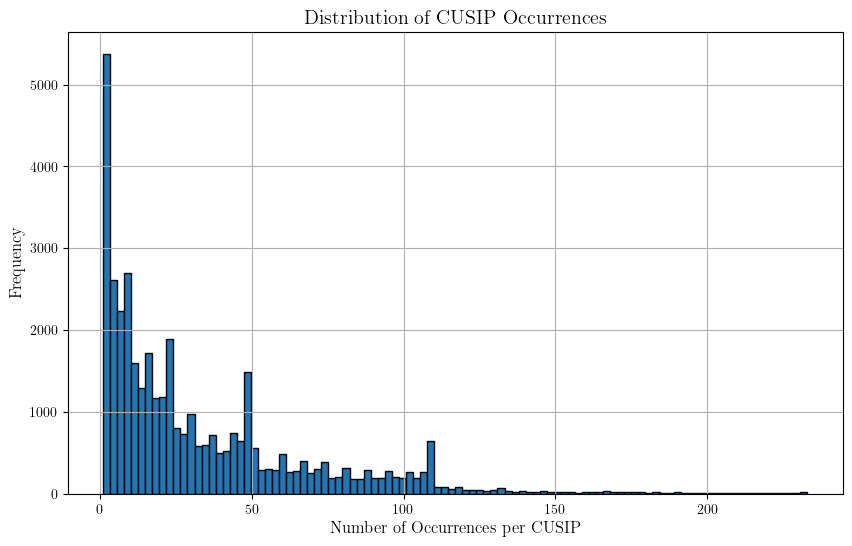

       count  count_cumul
count                    
1       2194         2194
2       1639         3833
3       1544         5377
4       1402         6779
5       1206         7985
...      ...          ...
229        4        38852
230        6        38858
231        5        38863
232        3        38866
233       11        38877

[231 rows x 2 columns]


In [16]:
# Seeing how many days of data does each unique bond have
bond_count = clean_bonds_long['cusip'].value_counts().reset_index()
print(bond_count)
print(bond_count.describe(),"\n")
print(bond_count.info())

plt.figure(figsize=(10, 6))
plt.hist(bond_count['count'], bins=100, edgecolor='black')
plt.xlabel('Number of Occurrences per CUSIP')
plt.ylabel('Frequency')
plt.title('Distribution of CUSIP Occurrences')
plt.grid(True)
plt.savefig(f"Plots/bond_cusip_dist.png", dpi=300, bbox_inches='tight')
plt.show()

# Also printing the cumulative frequency of all bond occurences
freq = bond_count['count'].value_counts().sort_index()
freq_df = pd.DataFrame(freq, columns=['count'])
freq_df['count_cumul'] = freq_df['count'].cumsum()
print(freq_df)

count     233.000000
mean     5581.540773
std       885.189479
min      3650.000000
25%      4840.000000
50%      5430.000000
75%      6198.000000
max      7347.000000
Name: count, dtype: float64 



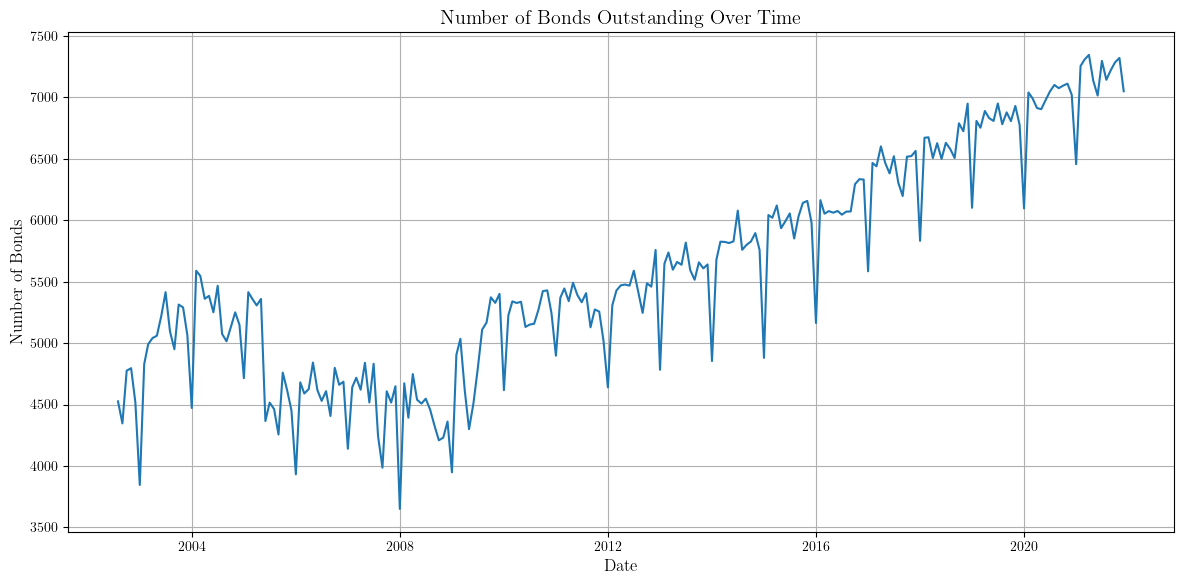

In [17]:
# Plotting the number of bonds available at each month end
day_count = clean_bonds_long.index.value_counts()
day_count = day_count.sort_index()

# Printing out statistics
print(day_count.describe(), "\n")

# Plotting the figure
plt.figure(figsize=(12,6))
plt.plot(day_count.index, day_count)
plt.xlabel("Date")
plt.ylabel("Number of Bonds")
plt.title("Number of Bonds Outstanding Over Time")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Plots/bonds_outstanding.png", dpi=300, bbox_inches='tight')
plt.show()

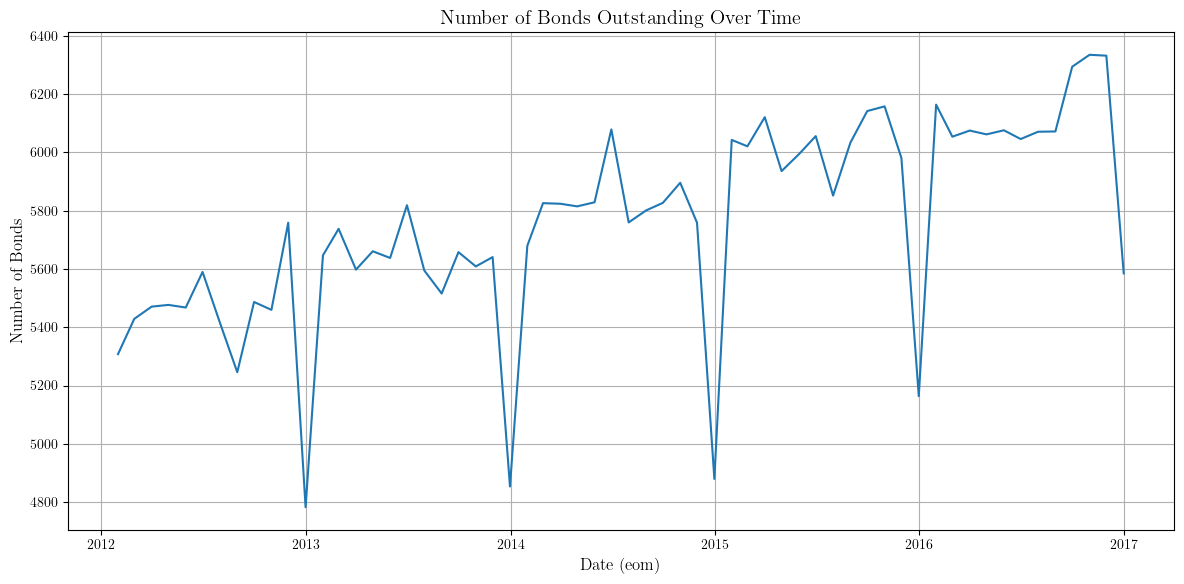

In [18]:
# Plotting the same number of bonds for a specified period
start = '2012-01-01'
end = '2017-01-01'
day_count_slice = day_count[day_count.index >= start].copy()
day_count_slice = day_count_slice[day_count_slice.index <= end]

# Plotting the number of bonds overtime
plt.figure(figsize=(12, 6))          
plt.plot(day_count_slice.index,            
         day_count_slice)         
plt.xlabel('Date (eom)')
plt.ylabel('Number of Bonds')
plt.title('Number of Bonds Outstanding Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Plots/bonds_outstanding_sliced.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Viewing bond features after pivoting
print(f"Unique Number of Bonds in the Dataset: {len(clean_bonds_long['cusip'].unique())}")
processed_bonds_ret

Unique Number of Bonds in the Dataset: 38877


cusip,000336AE7,00037BAA0,00037BAB8,00037BAC6,00037BAD4,00037BAE2,00037BAF9,00077QAA8,00077QAB6,00077QAC4,...,98978VAK9,98978VAL7,98978VAM5,98978VAN3,98978VAP8,98978VAQ6,98978VAS2,98978VAT0,989822AA9,U36964AK7
Date,,,,,,,,,,,,,,,,,,,,,
2002-08-31,0.005084,NaN,NaN,NaN,NaN,NaN,NaN,0.008741,0.030161,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013686,NaN
2002-09-30,-0.056349,NaN,NaN,NaN,NaN,NaN,NaN,0.007913,0.033869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062894,NaN
2002-10-31,0.050924,NaN,NaN,NaN,NaN,NaN,NaN,0.004529,-0.043209,-0.003631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.131872,NaN
2002-11-30,0.079503,NaN,NaN,NaN,NaN,NaN,NaN,-0.023597,0.026622,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151989,NaN
2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028813,-0.029565,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047762,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006461,0.013297,0.029045,0.014169,0.029238,NaN,0.020666,0.028684,0.006188,NaN
2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001388,-0.002873,-0.009335,-0.007120,-0.007815,NaN,-0.005161,-0.007925,-0.000338,NaN
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.009161,NaN,NaN,NaN,...,-0.004144,-0.007522,-0.037348,-0.008975,-0.028702,NaN,-0.013836,-0.029913,-0.004600,NaN


#### Observations
- A lot of bonds have less occurances (average of 36). As this is transaction data, if a few bonds were not transacted at the end of the month, that bond does not appear for that month end.
- Additionally, a lot of null values are present in the ret_exc column. As explained by the authors, if the bond prices were not available for the last five days, those returns are categorised as null.
- When it comes to seeing how many bonds are available on each of the month-end values, we can see that on average ~ 5000 bonds were active for all days. The minimum value recorded was 3650.
- Cyclicity is seen amongst the number of bonds. As this is based on transaction data, this may not entirely mean bonds are expiring, but may also imply when do most bond transactions take place.
- Taking a closer look, it is evident that a lot of the drops are happening at the end of the calendar year.

### Exploring Bloomberg Index Dataset

In [20]:
processed_index

,Idx_Price,Idx_Returns,Idx_Exc,Idx_MCap,Idx_Count
Date,,,,,
2002-08-31,1257.87,0.026523,0.025106,1666173.29,3580
2002-09-30,1281.86,0.019072,0.017739,1701668.57,3586
2002-10-31,1264.65,-0.013426,-0.014659,1673274.91,3574
2002-11-30,1284.43,0.015641,0.014599,1685374.02,3535
2002-12-31,1323.64,0.030527,0.029527,1736694.47,3530
...,...,...,...,...,...
2021-07-31,3563.68,0.013688,0.013646,6962832.37,6838
2021-08-31,3552.90,-0.003025,-0.003050,6957292.32,6902
2021-09-30,3515.50,-0.010527,-0.010585,6876915.12,6938


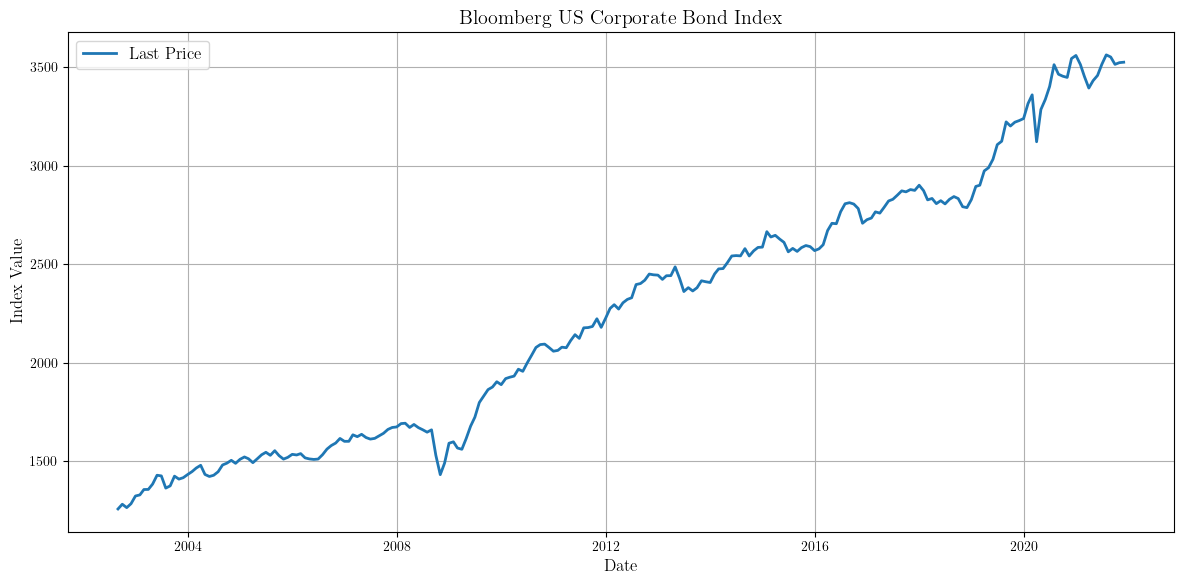

In [21]:
# Plotting the Bloomberg Index Value 
plt.figure(figsize=(12,6))
plt.plot(processed_index.index, processed_index['Idx_Price'], label='Last Price', color='#1f77b4', linewidth=2)
#plt.plot(processed_index.index, processed_index['LUACTRUU Index'], label='Gross Index Ret', color='#ff7f0e', linewidth=2, linestyle='--')
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("Bloomberg US Corporate Bond Index")
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Plots/bloomb_last_price.png", dpi=300, bbox_inches='tight')
plt.show()

[]

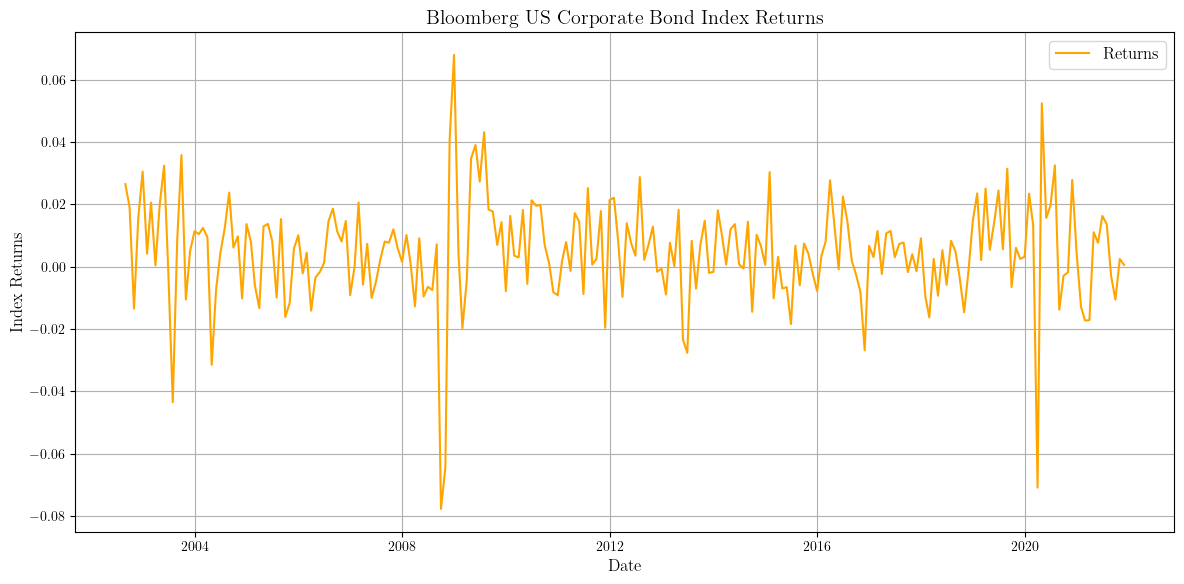

In [22]:
# Plotting the Index Returns
plt.figure(figsize=(12,6))
plt.plot(processed_index.index, processed_index['Idx_Returns'], color='orange', label='Returns')
plt.xlabel("Date")
plt.ylabel("Index Returns")
plt.title("Bloomberg US Corporate Bond Index Returns")
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Plots/bloomb_returns.png", dpi=300, bbox_inches='tight')
plt.plot()

In [23]:
processed_index.describe()

,Idx_Price,Idx_Returns,Idx_Exc,Idx_MCap,Idx_Count
count,232.000000,232.000000,232.000000,2.320000e+02,232.000000
mean,2256.028793,0.004707,0.003749,3.521348e+06,4391.586207
std,665.991739,0.016726,0.016803,1.652516e+06,1357.584407
min,1257.870000,-0.077692,-0.078542,1.576092e+06,2513.000000
25%,1600.655000,-0.003144,-0.005407,1.837887e+06,3165.750000
50%,2299.890000,0.005393,0.003831,3.294942e+06,4098.000000
75%,2788.417500,0.013705,0.012397,4.972268e+06,5667.500000
max,3563.680000,0.067965,0.067873,6.962832e+06,7029.000000


In [24]:
# Checking whether the time indices match
row_check_bonds = processed_bonds_ret.index.unique()
row_check_index = processed_index.index
row_check_bonds == row_check_index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

#### Observations
- The columns 'PX_LAST' and 'TOT_RETURN_INDEX_GROSS_DVDS' in the Bloomberg Index dataset is the same. This implies both of them are total return indices, which match with the returns calculated in the bonds dataset.
- As the paper calculated simple returns (Current/Last -1) for the bonds, the same simple returns have been calculated for the Bloomberg Index.
- After resampling Index data from daily to monthly, and slicing it to match the start and end dates from the bond data, both datasets have the same dates and the same number of observations, meaning these can be merged later on if required.

### Saving Outputs
- We save the processed outputs as a CSV, which will be used in model development and implementation, which is the next part of the pipeline.

In [25]:
%%time
# Saving all the processed variables as a CSV
clean_bonds_long.to_csv("clean_bond_returns_long.csv")
tbill.to_csv("clean_tbill.csv")
processed_bonds_ret.to_csv("processed_bond_returns.csv")
processed_index.to_csv("processed_index_returns.csv")
processed_bonds_mcap.to_csv("processed_bonds_mcap.csv")

CPU times: total: 10.1 s
Wall time: 10.2 s


In [26]:
clean_bonds_long

,cusip,market_value,ret_exc
Date,,,
2002-07-31,000336AE7,9.762500e+07,NaN
2002-07-31,2338E8AJ8,9.184000e+06,NaN
2002-07-31,2338E8AH2,6.492360e+06,NaN
2002-07-31,37042GTR7,2.560712e+07,NaN
2002-07-31,2338E8AG4,1.370510e+07,NaN
...,...,...,...
2021-11-30,74456QBX3,3.601198e+08,-0.000831
2021-11-30,031162AA8,2.000920e+08,NaN
2021-11-30,74456QBW5,3.378960e+08,-0.003965
